# Alignment of 3k PBMCs against ELDB.v20221214 (320k subset) in AWS
v2023-11-15

In [1]:
# delete the output to reset the tutorials
!rm -rf output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/

In [2]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc
# set figure parameters
sc.set_figure_params( dpi = 200, figsize = ( 8, 8 ), frameon = False )

# plotly export settings
import plotly.io as pio
pio.renderers.default = "notebook"

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

In [4]:
# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

ram_ref = RamData( 's3://scelephant-free/ELDB.combined_v20221214.subset_320000_barcodes.ramdata/', file_system_operator_pool = fop, name_layer = None, flag_enable_synchronization_through_locking = False, ) # does not contain full ELDB data (full dataset is a requester-pay bucket)
# ram_ref = RamData( 's3://scelephant/ELDB.combined_v20221214.ramdata/', file_system_operator_pool = fop, name_layer = None ) # contain full ELDB data, but it is requester-pay bucket, and it is not FREE
ram_query = RamData( f'output/pbmc3k.ram/', file_system_operator_pool = fop )

# build feature mapping using 'id_gene', not 'name_gene'
ram_ref.ft.int_index_str_rep = 0
ram_query.ft.int_index_str_rep = 0

ram = RamData(
    "output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/",
    l_ramdata = [ ram_ref, ram_query ],
    name_layer = None,
    int_total_weight_for_each_batch = 10_000_000,
    int_index_component_reference = 0,
    file_system_operator_pool = fop,
    flag_enable_synchronization_through_locking = False, # set to False (better performance)
)

2023-11-18 01:23:22,114 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


**view Combined RamData**
- JavaScript-based interactive visualization of 'Combined' RamData object in Jupyter Notebook

In [7]:
ram

<RamData object (322700 barcodes X 62914 features) stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/
	with the following layers : {'normalized_log1p_capped', 'normalized_log1p', 'normalized', 'raw'}
		current layer is 'None'>

In [8]:
"""
Get PCA values of the new barcodes
"""
# settings of the pipeline
l_anno_ori = [ 'leiden_scanpy' ]
flag_copy_pca_values = False # copy pca values of the reference database

name_col_bc_all = 'filtered_barcodes'

name_col_filter_ft = "filter_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp"
ram.ft.change_filter( name_col_filter_ft )

# create umap from scelephant-DB (Hs) using genes from which DEGs between data sources are removed
int_num_barcodes_in_pumap_batch = 10000000
int_num_barcodes_for_a_batch = 250000
float_prop_subsampling_pca = 1

# set the suffix of the run
name_model = 'ipca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp'

str_suffix_new = '_aligned'
str_suffix = '_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp'
name_col_pca = f'X_pca{str_suffix}{str_suffix_new}'

"""
Get PCA values
"""
model = ram.apply_pca( 
    name_model = f'ipca{str_suffix}', 
    name_layer = 'normalized_log1p_capped', 
    name_col = name_col_pca, 
    name_col_filter = f'filter_pca{str_suffix}{str_suffix_new}', 
    int_n_components_in_a_chunk = 20, 
    int_num_threads = 5,
    int_index_component_reference = 0,
)

2023-11-18 01:26:21,581 [aiobotocore.credentials] <INFO> (load) - Found credentials in shared credentials file: ~/.aws/credentials
2023-11-18 01:26:38,264 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 0
2023-11-18 01:26:45,165 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-18 01:26:45,168 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 1
2023-11-18 01:26:45,193 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-18 01:26:45,312 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
100 PCs from 10504 features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [9]:
"""
co-embedding of new barcodes
"""
str_num_subsampled_cells = '20480000'
name_model = f"knnindex__filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info__X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp__100comp__30_neighbors"
name_col_filter_bc_subsampled = f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info'
name_umap = 'X_umap_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_18097526_entries_30knn100comp_scanpy_spectral'
name_umap_combined = f'{name_umap}_combined'

ram.bc.change_filter( name_col_filter_bc_subsampled )

ram.bc.meta[ name_umap_combined ] = ram.bc.meta[ name_umap ] # copy original values

# perform embedding, while retrieving primary & secondary neighbors
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned',
    int_index_component_reference = 0,
)

# retrieve primary neighbors only
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned_primary',
    flag_include_secondary_neighbors_of_the_query = False,
    int_index_component_reference = 0,
)

2023-11-18 01:36:30,999 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-18 01:36:31,000 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 259736 entries in the index
embedder using 259736 entries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:01<00:00, 1799.15it/s]
2023-11-18 01:36:34,961 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-18 01:36:34,962 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 259736 entries in the index
embedder using 259736 entries: 100%|██████████████████████████████████████████

In [10]:
"""
Deep-learning based annotation prediction - using the cell types annotations from the Extended PBMC3k dataset
"""
name_anno_combined = f'extended_pbmc3k_predicted_cell_type'
name_anno = f'metadata__pbmc3k_alignment_primary_and_secondary_neighbors__cell_type'

# copy original values
ram.bc.filter = None # copy all values without lazy loading
ram.bc.meta[ name_anno_combined ] = ram.bc.meta[ name_anno ] # copy original values

ram.bc.filter = ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) # select the component 1
ram.apply_dl( 
    name_model = f'metadata__pbmc3k_alignment_primary_and_secondary_neighbors__cell_type.classifier',
    name_col_x = name_col_pca, 
    name_col_y = name_anno_combined,
    operation = 'classifier', 
    flag_apply_to_entries_used_for_training = True, 
    int_num_entries_in_a_batch = 500000, 
    int_num_threads = 5
)

2023-11-18 01:36:47.748982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 01:36:47.903350: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 01:36:47.940614: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 01:36:48.777846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3020.80it/s]


2023-11-18 01:37:02,453 [SC-Elephant] <INFO> (load_str) - [Axis features] completed loading of 10504 number of strings
2023-11-18 01:37:18,031 [SC-Elephant] <INFO> (load_str) - [Axis barcodes] completed loading of 262436 number of strings
2023-11-18 01:37:35,989 [SC-Elephant] <INFO> (__getitem__) - l = ['str']
2023-11-18 01:37:35,992 [SC-Elephant] <INFO> (__getitem__) - l = ['str', 'raw_sum', 'filter_external_data', 'extended_pbmc3k_predicted_cell_type', {'X_umap_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_18097526_entries_30knn100comp_scanpy_spectral_combined'}, 'leiden_scanpy', 'annotation_label_predicted_resol_0.1', 'annotation_label_predicted_resol_0.5', 'annotation_label_predicted_resol_1', 'annotation_label_predicted_resol_2', 'annotation_label_predicted_resol_5', 'annotation_label_predicted_resol_10', 'annotation_label_predicted_resol_20', 'annotation_label_predicted_resol_30']
... storing 'filter_external_dat

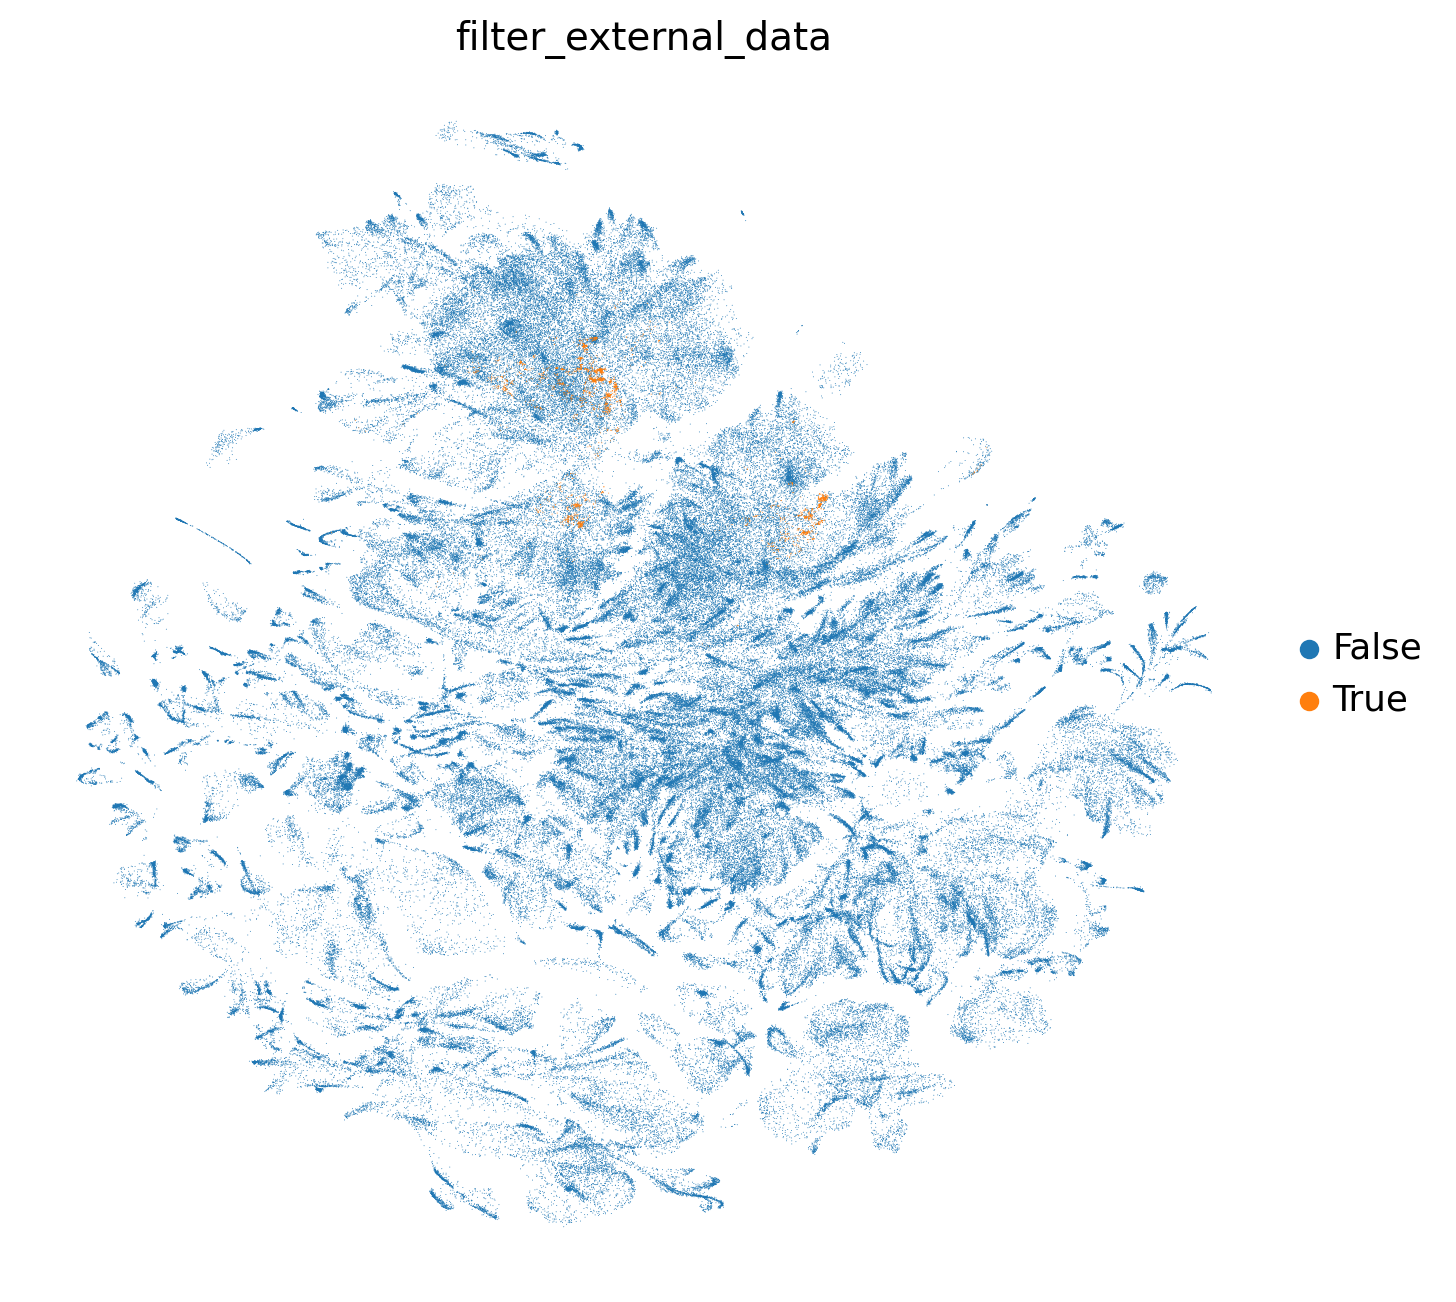

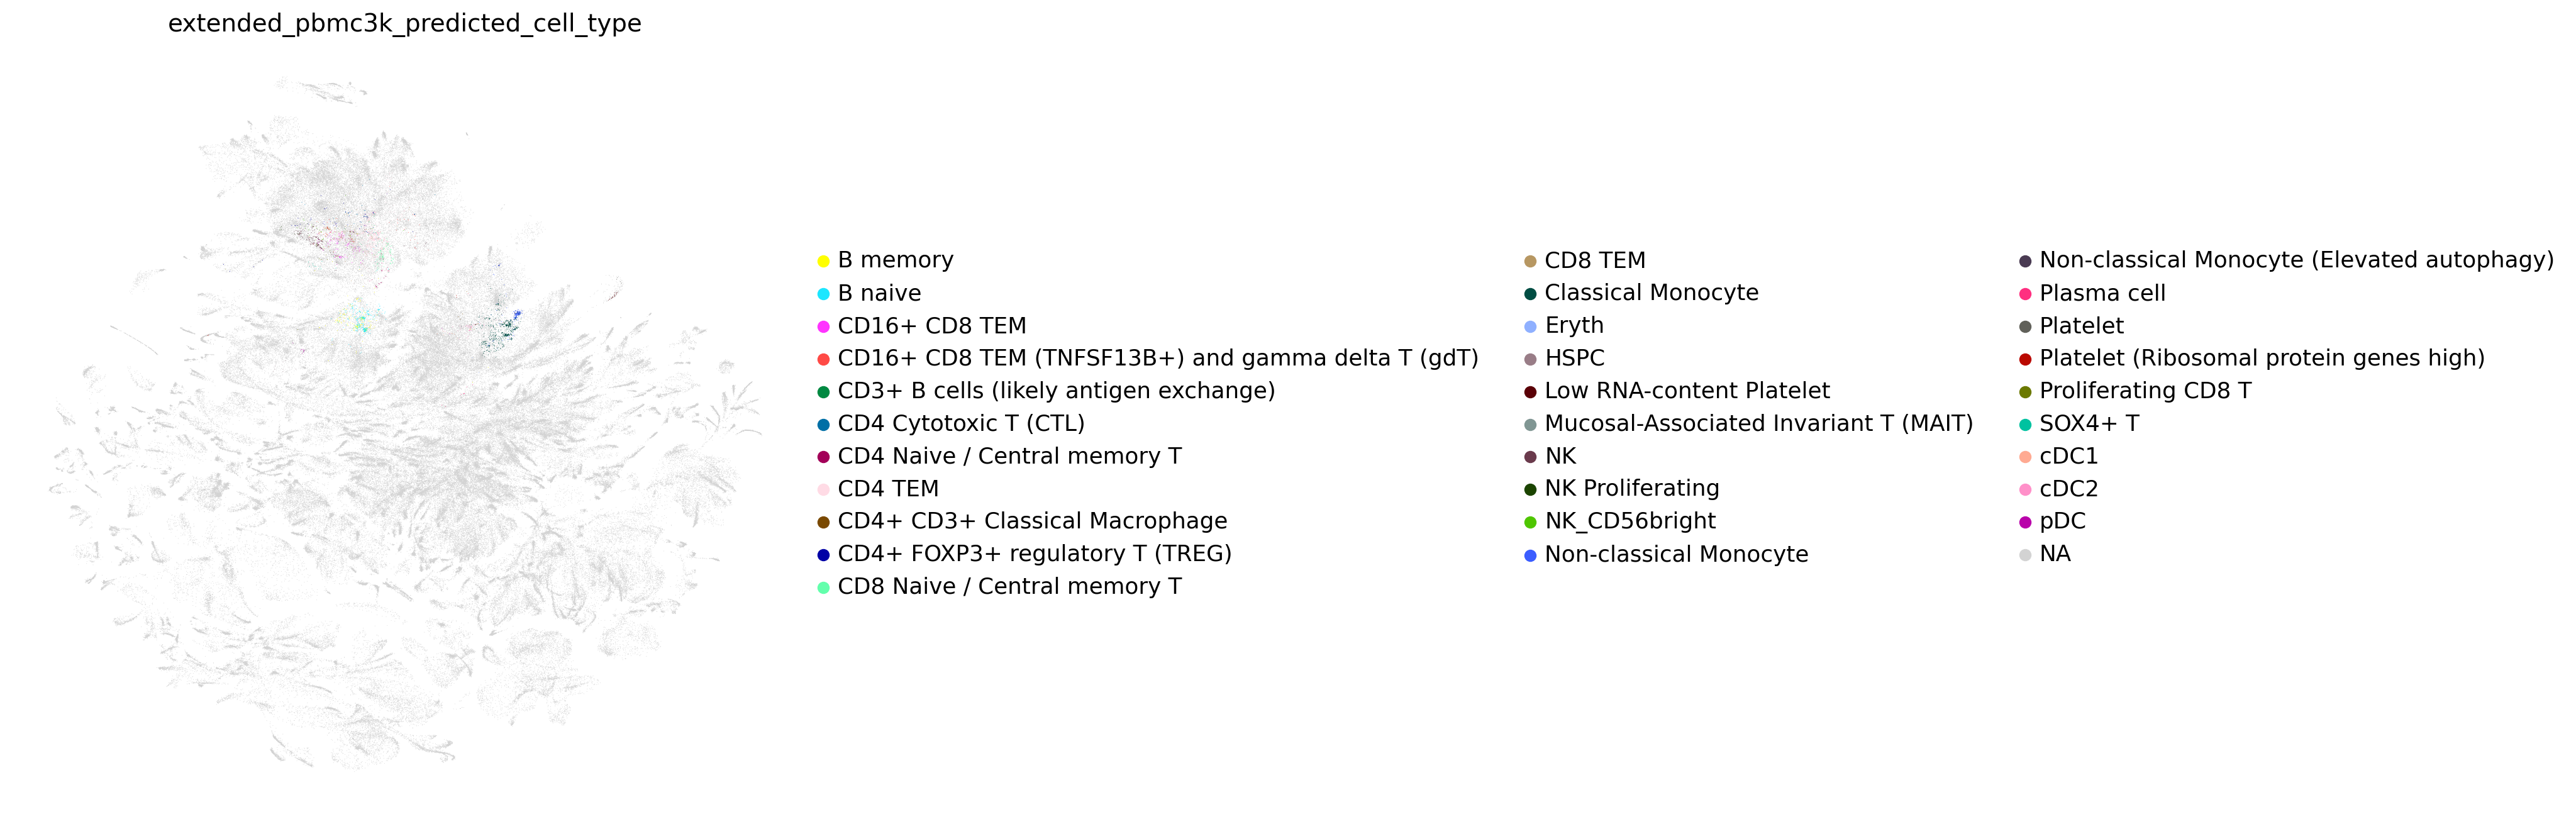

In [11]:
'''
set filter of the external data (dataset of interest)
'''
# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) )

ram.ft.load_str( )

# save as a filter
ram.bc.save_as_filter(
    ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ),
    'filter_external_data'
)

"""
plot co-embedded cells
"""
# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) )

adata = ram[ 
    'normalized_log1p_capped', 
    :, 
    [ "str", 'raw_sum', 'filter_external_data', f'extended_pbmc3k_predicted_cell_type', { name_umap_combined } ] + l_anno_ori + list( f'annotation_label_predicted_resol_{resol}' for resol in [ 0.1, 0.5, 1, 2, 5, 10, 20, 30 ] ), 
    ['ACTA2', 'COL1A1', 'TAGLN', 'MYL9', 'COX4I2', 'MKI67', 'CDH5', 'SRGN', 'ACTC1', 'SPP1', 'VCAM1', 'PLCB4', 'KRT19', 'MSI2', 'COLEC11', 'SGIP1', 'MMP11', 'APOA2', 'FLT1', 'POU5F1', 'KRT19', 'COL4A2', 'POSTN', 'CCL19', 'CCL21'], 
    [ 'str' ]
]
adata.obsm[ 'X_umap' ] = adata.obsm[ name_umap_combined ]
adata.obs[ 'filter_external_data' ] = adata.obs[ 'filter_external_data' ].astype( str ).astype( object )
    
sc.pl.umap( adata, color = 'filter_external_data' )

"""
plot predicted annotations
"""   
sc.pl.umap( adata, color = 'extended_pbmc3k_predicted_cell_type' ) # cell types annotations from the Extended PBMC3k dataset

In [12]:
"""
compare annotations
"""
def Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap : int = 3, flag_show_label : bool = True, font_size : int = 10, title : str = '', dict_color : dict = dict( ) ) :
    """ # 2023-03-05 16:32:49 
    draw a Shankey diagram using Plotly for the given lists of annotations
    
    l_anno_1 # first list of annotations 
    l_anno_2 # second list of annotations 
    int_min_num_entries_for_an_overlap : int = 3 # the minmum number of entries for a link (overlaps between two annotations) to be valid.
    title : Union[ None, str ] = None # the name of the figure. if None is given, no title will be shown
    font_size : int = 10, # the font size of the title
    dict_color : dict = dict( ), # name of the label to color mapping
    """
    import numpy as np
    def _map( arr_anno, start_pos : int = 0 ) :
        """
        return a dictionary for mapping annotation to its integer representation and a list of unique annotation labels
        """
        l_anno_unique = el.bk.LIST_COUNT( arr_anno, duplicate_filter = None ).index.values # retrieve a list of unique annotations
        return dict( ( e, i + start_pos ) for i, e in enumerate( l_anno_unique ) ), l_anno_unique

    dict_map_1, arr_anno_unique_1 = _map( l_anno_1, start_pos = 0 )
    dict_map_2, arr_anno_unique_2 = _map( l_anno_2, start_pos = len( dict_map_1 ) )
    label = list( arr_anno_unique_1 ) + list( arr_anno_unique_2 ) if flag_show_label else None # compose a list of unique labels # does not show labels if 'flag_show_label' is False

    # retrieve values for drawing the diagram
    source, target, value = el.bk.LIST_COUNT( np.array( [ list( dict_map_1[ e ] for e in l_anno_1 ), list( dict_map_2[ e ] for e in l_anno_2 ) ], dtype = int ).T, duplicate_filter = int_min_num_entries_for_an_overlap ).reset_index( drop = False ).values.T
    # compose a dataframe
    
    # draw a plot
    import plotly.graph_objects as go

    fig = go.Figure( data = [ go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict( color = "black", width = 0.5 ),
          label = label,
          color = list( dict_color[ e ] if e in dict_color else 'blue' for e in label ),
        ),
        link = dict(
          source = source, 
          target = target,
          value = value
      ))])
    if title is not None :
        fig.update_layout( title_text = title, font_size = font_size )
    return fig
def Get_dict_color( adata, name_col : str ) :
    ''' get name_category > color mapping of a given column in the .obs of a given AnnData '''
    try :
        return dict( ( n, c ) for n, c in zip( adata.obs[ name_col ].cat.categories, adata.uns[ name_col + '_colors' ] ) )
    except :
        return dict( )
    
# define the folder containing the data
path_folder_graph = f'output/graph/'
os.makedirs( path_folder_graph, exist_ok = True ) # create the output folder
dict_color_ori = {'0': '#1f77b4', '1': '#ff7f0e', '2': '#2ca02c', '3': '#d62728', '4': '#9467bd', '5': '#8c564b', '6': '#e377c2', '7': '#7f7f7f', '8': '#bcbd22', '9': '#17becf' } # colors of the original annotations
name_anno_ori = l_anno_ori[ 0 ] # name of the columns containing original annotations

# cell types annotations from the Extended PBMC3k dataset
name_anno_combined = f'extended_pbmc3k_predicted_cell_type'
name_anno = f'metadata__pbmc3k_alignment_primary_and_secondary_neighbors__cell_type'

l_anno_1, l_anno_2 = adata.obs.loc[ adata.obs[ 'filter_external_data' ] == 'True', [ name_anno_ori, name_anno_combined ] ].values.T
fig = Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap = 20, flag_show_label = True, title = name_anno_combined, dict_color = { ** dict_color_ori, ** Get_dict_color( adata, name_anno_combined ) } )
fig.show( )
fig.write_html( f"{path_folder_graph}plotly.shankey_comparison.{name_anno_ori}.{name_anno_combined}.html" )